# Import Libraries


In [1]:
# General libraries
import pandas as pd
import numpy as np
import ast
import joblib

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Data sampling and balancing
from imblearn.over_sampling import SMOTE

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2

# Sparse matrix operations
from scipy.sparse import csr_matrix, coo_matrix

# Load the Dataset


In [2]:
df = pd.read_csv("dataset/movies_metadata.csv", low_memory=False)
ratings_df = pd.read_csv('dataset/ratings_small.csv')

# Check for missing values or unexpected data types
    # for movie
print(df.columns)  
print(df.isnull().sum())  

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline 

In [3]:
    # for rating
print(ratings_df.columns) 
print(ratings_df.isnull().sum())  

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


# Filter Dataset

In [4]:
# Convert movie IDs to numeric
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df.dropna(subset=['id'], inplace=True)
df['id'] = df['id'].astype(int)

# === BEFORE FILTERING ===
print("=== BEFORE FILTERING ===")
print("Movies Total  :", len(df))
print("Ratings Total :", len(ratings_df))
print()

# ─── Popular Movie Filter ───
min_votes = 100
min_rating = 3.5
df = df[(df['vote_count'] >= min_votes) & (df['vote_average'] >= min_rating)]
df.reset_index(drop=True, inplace=True)

# ─── Sync ratings with filtered movies ───
popular_movie_ids = df['id'].unique()
ratings_df = ratings_df[ratings_df['movieId'].isin(popular_movie_ids)]

# === AFTER FILTERING ===
print("=== AFTER FILTERING ===")
print("Popular Movies Retained :", len(df))
print("Ratings Retained        :", len(ratings_df))


=== BEFORE FILTERING ===
Movies Total  : 45463
Ratings Total : 100004

=== AFTER FILTERING ===
Popular Movies Retained : 6047
Ratings Retained        : 26125


# Data Cleaning

In [5]:
# weighted rating formula
def weighted_rating(x, C, m):
    v = x['vote_count']  
    R = x['vote_average']  
    return (v * R + C * m) / (v + C) if v >= m else R   

In [6]:
# Calculate the mean vote count and mean rating 
C = df['vote_count'].mean()  
m = df['vote_average'].mean()  

# Apply the weighted rating 
df['weighted_rating'] = df.apply(weighted_rating, axis=1, C=C, m=m)

In [7]:
# Keep only necessary columns
df = df[['id', 'title', 'overview', 'genres', 'vote_average', 'vote_count', 'weighted_rating']]
# Drop nulls in important fields
df.dropna(subset=['title', 'overview', 'genres', 'vote_average', 'vote_count', 'weighted_rating'], inplace=True)
# Drop duplicates by title (some movies have repeated entries)
df.drop_duplicates(subset='title', inplace=True)

In [8]:
# Fix genre string to list of names
def parse_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return ' '.join([g['name'] for g in genres])
    except:
        return ''

df['genres'] = df['genres'].apply(parse_genres)
# Drop rows with empty genres after parsing
df = df[df['genres'].str.strip() != '']

In [9]:
# Combine genres + overview
df['content'] = df['genres'] + ' ' + df['overview']

# Replace NaN values in 'content' with an empty string
df['content'] = df['content'].fillna('')

In [10]:
# Final clean-up
df.reset_index(drop=True, inplace=True)

# Preview cleaned data
df[['title', 'genres', 'content', 'vote_average', 'vote_count', 'weighted_rating']].head()

,title,genres,content,vote_average,vote_count,weighted_rating
0,Toy Story,Animation Comedy Family,"Animation Comedy Family Led by Woody, Andy's t...",7.7,5415.0,7.549469
1,Jumanji,Adventure Fantasy Family,Adventure Fantasy Family When siblings Judy an...,6.9,2413.0,6.790646
2,Father of the Bride Part II,Comedy,Comedy Just when George Banks has recovered fr...,5.7,173.0,6.287509
3,Heat,Action Crime Drama Thriller,Action Crime Drama Thriller Obsessive master t...,7.7,1886.0,7.346126
4,Sabrina,Comedy Romance,Comedy Romance An ugly duckling having undergo...,6.2,141.0,6.390453


In [11]:
# Check for missing values or unexpected data types
print(df.columns)  # List all columns
print(df.isnull().sum())  # Check missing values in each column

Index(['id', 'title', 'overview', 'genres', 'vote_average', 'vote_count',
       'weighted_rating', 'content'],
      dtype='object')
id                 0
title              0
overview           0
genres             0
vote_average       0
vote_count         0
weighted_rating    0
content            0
dtype: int64


In [12]:
# Vectorize the combined content column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_content = tfidf_vectorizer.fit_transform(df['content'])

# Display shape of the resulting feature matrix
print("TF-IDF feature matrix shape:", X_content.shape)

TF-IDF feature matrix shape: (5879, 22702)



# Dataset Information

## Rating Distributions

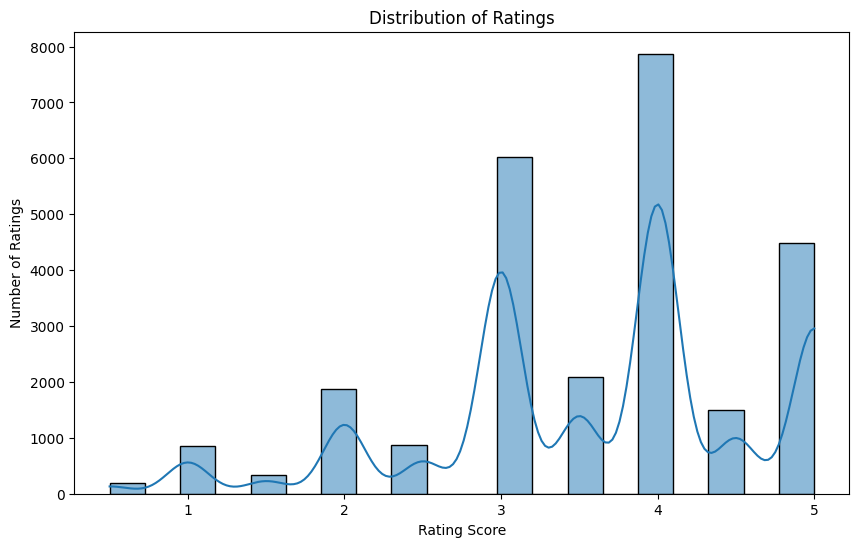

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(ratings_df['rating'], kde=True, bins=20)
plt.title('Distribution of Ratings')
plt.xlabel('Rating Score')
plt.ylabel('Number of Ratings')
plt.show()

## Top 10 Most Common Genres

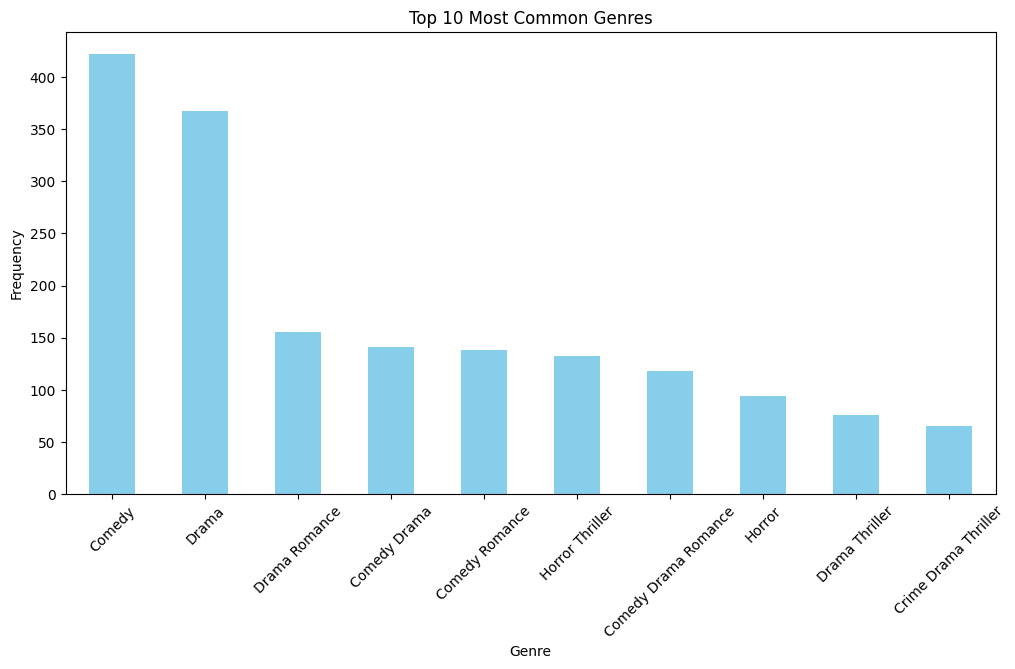

In [14]:
df['genres'] = df['genres'].fillna('')
genre_list = df['genres'].str.split(',', expand=True).stack().reset_index(drop=True)
genre_counts = genre_list.value_counts()

# Plot the most common genres
plt.figure(figsize=(12,6))
genre_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Common Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Correlation Between Average Rating and Number of Ratings

Correlation (avg_rating vs. num_ratings): 0.178


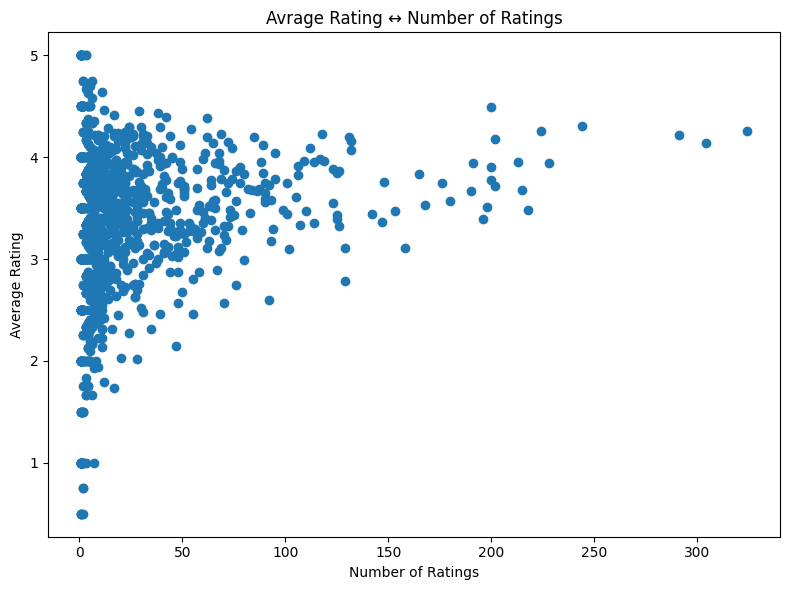

In [15]:
agg = (ratings_df
       .groupby("movieId")
       .agg(avg_rating=("rating","mean"),
            num_ratings=("userId","count"))
       .reset_index())

# 3) Compute Pearson correlation
corr = agg["avg_rating"].corr(agg["num_ratings"])
print(f"Correlation (avg_rating vs. num_ratings): {corr:.3f}")

# 4) Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(agg["num_ratings"], agg["avg_rating"])
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.title("Avrage Rating ↔ Number of Ratings")
plt.tight_layout()
plt.show()

## User Activity

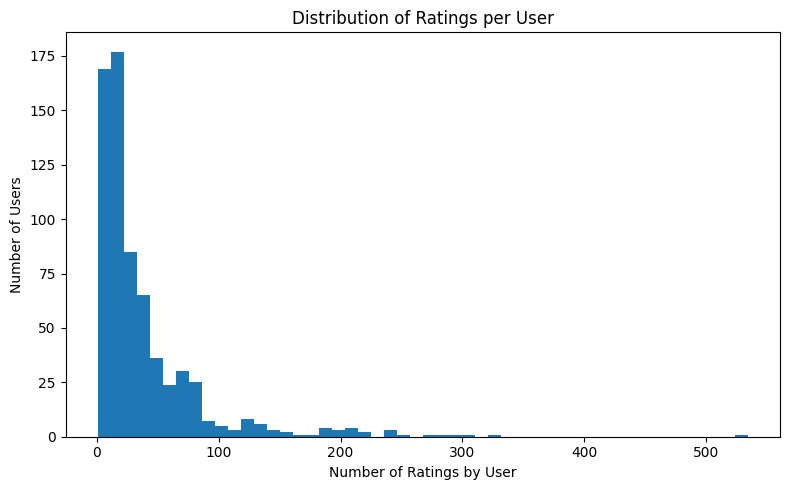

In [16]:
ratings_per_user = ratings_df['userId'].value_counts()

plt.figure(figsize=(8, 5))
plt.hist(ratings_per_user, bins=50)
plt.xlabel("Number of Ratings by User")
plt.ylabel("Number of Users")
plt.title("Distribution of Ratings per User")
plt.tight_layout()
plt.show()


,userId,rating_count
0,564,534
1,547,327
2,452,305
3,311,296
4,15,280
5,509,273
6,468,255
7,30,244
8,518,242
9,73,241


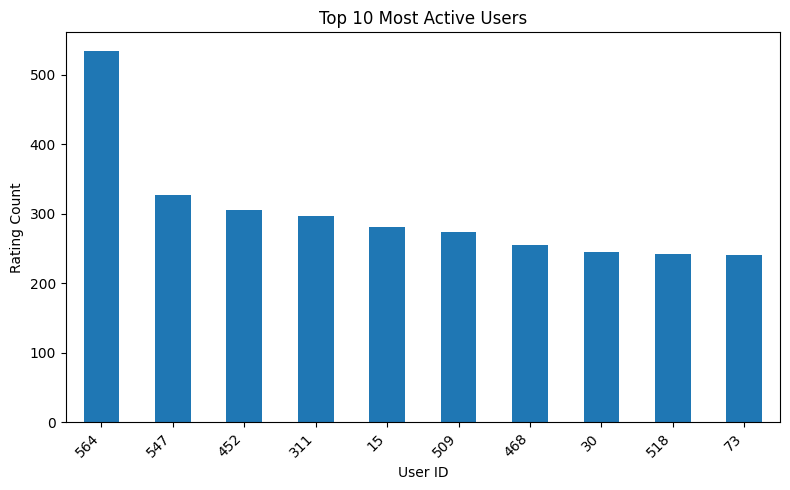

In [17]:

top10 = ratings_per_user.head(10)
display(top10.rename_axis("userId").reset_index(name="rating_count"))

plt.figure(figsize=(8, 5))
top10.plot(kind='bar')
plt.xlabel("User ID")
plt.ylabel("Rating Count")
plt.title("Top 10 Most Active Users")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Recommendation Logic


## Content-Based 

In [18]:
df_sample = df  
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_sample = tfidf_vectorizer.fit_transform(df_sample['content'])

# Truncated SVD with fewer components 
svd = TruncatedSVD(n_components=20, random_state=42)
X_reduced = svd.fit_transform(X_sample)
cosine_sim = cosine_similarity(X_reduced, dense_output=False)  

## Collaborative Filtering (using User-Item Matrix and KNN)

In [19]:
pivot_df = (
    ratings_df
      .pivot(index='userId', columns='movieId', values='rating')
      .fillna(0)
)
user_item_matrix = pivot_df  

# Cosine similarity
pivot_sparse = csr_matrix(pivot_df.values)
cosine_sim_user_item = cosine_similarity(pivot_sparse, dense_output=False)


In [20]:
# Title Similarity 
tfidf_title    = TfidfVectorizer(stop_words='english')
title_matrix   = tfidf_title.fit_transform(df['title'])        
title_sparse   = csr_matrix(title_matrix)                   
cosine_sim_title = cosine_similarity(
    title_sparse,
    title_sparse,
    dense_output=False                                       
)

# Genre Similarity 
count_genre    = CountVectorizer(tokenizer=lambda s: s.split('|'))
genre_matrix   = count_genre.fit_transform(df['genres'].fillna(''))  
genre_sparse   = csr_matrix(genre_matrix)
cosine_sim_genre = cosine_similarity(
    genre_sparse,
    genre_sparse,
    dense_output=False
)

C:\Users\evago\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
# Build lookups for CF boosting 
movieid_to_idx = { mid: i for i, mid in enumerate(df['id']) }
idx_to_movieid = { i: mid for mid, i in movieid_to_idx.items() }

def cf_liked_indices(user_id,
                     cosine_sim_user_item,
                     user_item_matrix,
                     min_rating=3.5,
                     top_k=10):
    """
    Return the set of movie-indices that the top_k users 
    most similar to `user_id` gave at least `min_rating`.
    """
    # similarity vector for this user → all other users
    sim_vector = cosine_sim_user_item[user_id].toarray().flatten()
    # pick top_k neighbors (skip self at position  user_id )
    neighbors = np.argsort(sim_vector)[::-1][1:top_k+1]
    
    liked = set()
    for nbr in neighbors:
        ratings = user_item_matrix[nbr].toarray().flatten()
        liked |= set(np.where(ratings >= min_rating)[0])
    return liked


## Collaborative filtering (using user-item matrix)

In [22]:
def collaborative_filtering(user_id, cosine_sim_user_item, user_item_matrix, top_k=10):
    row_idx = user_item_matrix.index.get_loc(user_id)
    sim_vec = cosine_sim_user_item[row_idx].toarray().flatten()

    # Top‐k neighbor *positions*
    neigh_pos = sim_vec.argsort()[::-1][1:top_k+1]

    recs = set()
    for pos in neigh_pos:
        ratings = user_item_matrix.iloc[pos, :].to_numpy()
        recs |= set(np.where(ratings > 0)[0])
    return recs


## Hybrid Recommender (Combine both content-based and collaborative results)

In [23]:
def hybrid_recommender(movie_name, user_id,
                       cosine_sim_title,
                       cosine_sim_genre,
                       user_item_matrix,
                       cosine_sim_user_item,
                       movies_df,
                       N=10,
                       m=500):

    if movie_name not in movies_df['title'].values:
        return []

    C = movies_df['vote_average'].mean()
    idx_to_mid = movies_df['id'].to_dict()
    idx = movies_df.index[movies_df['title'] == movie_name][0]

    title_sim = cosine_sim_title[idx].toarray().flatten()
    genre_sim = cosine_sim_genre[idx].toarray().flatten()

    # top 50 neighbours by title & genre
    title_idxs = [i for i,_ in sorted(enumerate(title_sim),
                                      key=lambda x: x[1], reverse=True)[1:51]]
    genre_idxs = [i for i,_ in sorted(enumerate(genre_sim),
                                      key=lambda x: x[1], reverse=True)[1:51]]
    candidates = list(set(title_idxs) | set(genre_idxs) - {idx})

    # Score by weighted‐rating 
    def wr(i):
        v = movies_df.at[i, 'vote_count']
        R = movies_df.at[i, 'vote_average']
        return (v/(v+m))*R + (m/(v+m))*C

    scored = sorted([(i, wr(i)) for i in candidates],
                    key=lambda x: x[1], reverse=True)[:20]
    top_idxs   = [i for i,_ in scored]
    rating_map = {i:score for i,score in scored}

    # CF boost 
    liked_movieIds = set()
    if user_id in user_item_matrix.index:
        row_pos = user_item_matrix.index.get_loc(user_id)
        sim_vec = cosine_sim_user_item[row_pos].toarray().flatten()
        # pick top‐10 neighbor positions (skip self)
        neigh_pos = np.argsort(sim_vec)[::-1][1:11]

        liked_pos = set()
        for np_ in neigh_pos:
            ratings = user_item_matrix.iloc[np_, :].to_numpy()
            liked_pos |= set(np.where(ratings >= 3.5)[0])

        # turn those positions into real movieIds
        liked_movieIds = {
            user_item_matrix.columns[pos]
            for pos in liked_pos
            if pos < len(user_item_matrix.columns)
        }

    # Build final boosted ranking
    final = []
    for i in top_idxs:
        mid   = idx_to_mid[i]
        boost = 1.0 if mid in liked_movieIds else 0.0
        final.append((i, rating_map[i] + boost))

    final = sorted(final, key=lambda x: x[1], reverse=True)[:N]

    # Return the movie titles 
    return movies_df.loc[[i for i,_ in final], 'title'].tolist()


## Example output

In [24]:
movie_name = "Toy Story"
user_id    = 1

if movie_name in df['title'].values:
    recs = hybrid_recommender(
        movie_name,
        user_id,
        cosine_sim_title,
        cosine_sim_genre,
        user_item_matrix,
        cosine_sim_user_item,
        df,
        N=10,
        m=500
    )

    # print top-10
    print(f"Top 10 recommendations for '{movie_name}':\n")
    for idx, title in enumerate(recs, start=1):
        details = df[df['title'] == title].iloc[0]
        print(
            f"{idx}. {title}  |  "
            f"Genres: {details['genres']}  |  "
            f"Avg Rating: {details['vote_average']:.1f}  |  "
            f"W-Rating: {details['weighted_rating']:.1f}"
        )
else:
    print("Movie not found in the dataset.")


Top 10 recommendations for 'Toy Story':

1. Monsters, Inc.  |  Genres: Animation Comedy Family  |  Avg Rating: 7.5  |  W-Rating: 7.4
2. Toy Story 3  |  Genres: Animation Family Comedy  |  Avg Rating: 7.6  |  W-Rating: 7.4
3. Heat  |  Genres: Action Crime Drama Thriller  |  Avg Rating: 7.7  |  W-Rating: 7.3
4. Casino  |  Genres: Drama Crime  |  Avg Rating: 7.8  |  W-Rating: 7.3
5. Rogue One: A Star Wars Story  |  Genres: Action Adventure Science Fiction  |  Avg Rating: 7.4  |  W-Rating: 7.3
6. Toy Story 2  |  Genres: Animation Comedy Family  |  Avg Rating: 7.3  |  W-Rating: 7.2
7. Despicable Me 2  |  Genres: Animation Comedy Family  |  Avg Rating: 7.0  |  W-Rating: 6.9
8. The Straight Story  |  Genres: Drama  |  Avg Rating: 7.7  |  W-Rating: 6.8
9. Tokyo Story  |  Genres: Drama  |  Avg Rating: 8.2  |  W-Rating: 6.8
10. Perfume: The Story of a Murderer  |  Genres: Crime Fantasy Drama  |  Avg Rating: 7.1  |  W-Rating: 6.8


# Save the Cleaned Data

In [25]:
# Save the final filtered datasets
df.to_csv('filtered_movies_metadata.csv', index=False)
ratings_df.to_csv('filtered_ratings.csv', index=False)
print("Filtered data saved as 'filtered_movies_metadata.csv' and 'filtered_ratings.csv'")


Filtered data saved as 'filtered_movies_metadata.csv' and 'filtered_ratings.csv'


# Define the Target Variable 


In [26]:
# Regression target 
y_reg = df['weighted_rating']

# Compute our three‐class cutoffs 
C     = df['weighted_rating'].mean()   
sigma = df['weighted_rating'].std()    

low  = C - sigma
high = C + sigma

# ─── 3. Three‐class classification target ───
#      0 = Dislike (< low)
#      1 = Neutral (between low/high)
#      2 = Like    (> high)
df['rating_class'] = np.select(
    condlist = [
      df['weighted_rating'] <  low,
      df['weighted_rating'].between(low, high),
      df['weighted_rating'] >  high
    ],
    choicelist = [0, 1, 2],
    default    = 1
)

y_cls3 = df['rating_class']  

In [27]:
df.to_csv('cleaned_movies_metadata.csv', index=False)
print("Saved with rating_class included.")

Saved with rating_class included.


# Train-Test Split


## Classification Target

In [28]:
# Classification Target (three‐class on weighted_rating)
X_classification = df[['vote_count','vote_average','weighted_rating']]
y_classification = df['rating_class']  

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_classification,
    y_classification,
    test_size=0.2,
    random_state=42,
    stratify=y_classification        
)

# Train-test split for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Check the shapes of the classification data
print(f"Training data shape (classification): X_train_class={X_train_class.shape}, y_train_class={y_train_class.shape}")
print(f"Testing data shape (classification): X_test_class={X_test_class.shape}, y_test_class={y_test_class.shape}")


Training data shape (classification): X_train_class=(4703, 3), y_train_class=(4703,)
Testing data shape (classification): X_test_class=(1176, 3), y_test_class=(1176,)


## Regression Target

In [29]:
# Regression Target (predicting the rating)
X_regression = df[['vote_count','vote_average','weighted_rating']]
y_regression = df['weighted_rating']    

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression,
    y_regression,
    test_size=0.2,
    random_state=42
)

# Train-test split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Check the shapes of the regression data
print(f"Training data shape (regression): X_train_reg={X_train_reg.shape}, y_train_reg={y_train_reg.shape}")
print(f"Testing data shape (regression): X_test_reg={X_test_reg.shape}, y_test_reg={y_test_reg.shape}")


Training data shape (regression): X_train_reg=(4703, 3), y_train_reg=(4703,)
Testing data shape (regression): X_test_reg=(1176, 3), y_test_reg=(1176,)


# Model Training


## Approach 1: KNN + Linear Regression

In [30]:
# Initialize KNN for classification
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_class, y_train_class)  # Fit the model on training data

# Initialize Linear Regression for regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)  # Fit the regression model

LinearRegression()

## Approach 2: SVM

In [31]:
# Initialize SVM for classification (SVC)
svm_clf = SVC(kernel='linear', C=1)
svm_clf.fit(X_train_class, y_train_class)  # Fit the model on classification data

# Initialize SVM for regression (SVR)
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train_reg, y_train_reg)  # Fit the regression model


SVR(kernel='linear')

## Approach 3: Random Forest + GBM

In [32]:
# Initialize Random Forest for classification
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_class, y_train_class)  

# Initialize Gradient Boosting for classification
gb_clf = GradientBoostingClassifier(n_estimators=100)
gb_clf.fit(X_train_class, y_train_class)  

# Initialize Random Forest for regression
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train_reg, y_train_reg)  

# Initialize Gradient Boosting for regression
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(X_train_reg, y_train_reg)  

GradientBoostingRegressor()

## Save models

In [33]:
# Save KNN + Linear Regression models
joblib.dump(knn_clf, 'knn_classifier.pkl')
joblib.dump(lin_reg, 'linear_regressor.pkl')

# Save SVM models
joblib.dump(svm_clf, 'svm_classifier.pkl')
joblib.dump(svm_reg, 'svm_regressor.pkl')

# Save Random Forest + GBM models for classification and regression
joblib.dump(rf_clf, 'random_forest_classifier.pkl')
joblib.dump(gb_clf, 'gb_classifier.pkl')
joblib.dump(rf_reg, 'random_forest_regressor.pkl')
joblib.dump(gb_reg, 'gb_regressor.pkl')

print("All models saved successfully.")

All models saved successfully.


# Evaluation Functions

## Classification

In [34]:
def evaluate_classification(name, y_true, y_pred):
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_true, y_pred))  # Classification report for performance metrics
    cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Plot confusion matrix heatmap
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## Regression

In [35]:
def evaluate_regression(name, y_true, y_pred):
    print(f"\n{name} Regression Metrics:")
    print(f"MAE:", mean_absolute_error(y_true, y_pred))  # Mean Absolute Error
    print(f"MSE:", mean_squared_error(y_true, y_pred))  # Mean Squared Error
    print(f"R2 Score:", r2_score(y_true, y_pred))  # R-squared (goodness of fit)


# Run Evaluation

## Approach 1: KNN + Linear Regression


KNN Classification Report:

              precision    recall  f1-score   support

           0       0.34      0.17      0.23       124
           1       0.83      0.94      0.89       905
           2       0.62      0.39      0.48       147

    accuracy                           0.79      1176
   macro avg       0.60      0.50      0.53      1176
weighted avg       0.76      0.79      0.76      1176



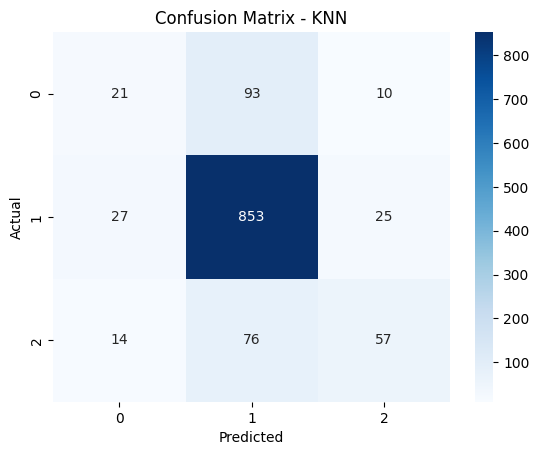


Linear Regression (KNN) Regression Metrics:
MAE: 1.2414106024329046e-14
MSE: 3.932236832495428e-28
R2 Score: 1.0


In [36]:
# KNN Classification + Linear Regression for regression

# KNN for classification
from sklearn.neighbors import KNeighborsClassifier
clf1 = KNeighborsClassifier()
clf1.fit(X_train_class, y_train_class)
y_pred_knn_class = clf1.predict(X_test_class)

# Linear Regression for regression
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression()
reg1.fit(X_train_reg, y_train_reg)
y_pred_knn_reg = reg1.predict(X_test_reg)

# Evaluate the models
evaluate_classification("KNN", y_test_class, y_pred_knn_class)
evaluate_regression("Linear Regression (KNN)", y_test_reg, y_pred_knn_reg)


## Approach 2: SVM


SVM Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       124
           1       1.00      0.97      0.99       905
           2       0.94      1.00      0.97       147

    accuracy                           0.98      1176
   macro avg       0.94      0.99      0.97      1176
weighted avg       0.98      0.98      0.98      1176



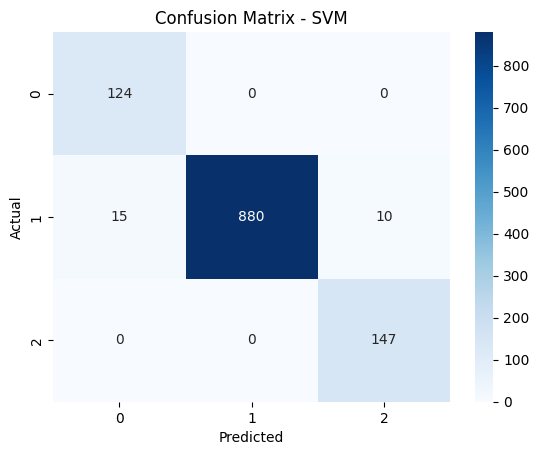


SVR Regression Metrics:
MAE: 0.07270675037283243
MSE: 0.006064614260718315
R2 Score: 0.953721311867258


In [ ]:
# Classification
svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(class_weight='balanced', decision_function_shape='ovr'))
])

param_grid_svc = {
    'svc__C':     [0.1, 1],       
    'svc__kernel':['linear'],      
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_svc = GridSearchCV(
    svc_pipe,
    param_grid_svc,
    cv=cv,
    scoring='accuracy',
    n_jobs=1              
)
grid_svc.fit(X_train_class, y_train_class)

best_svc = grid_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test_class)
evaluate_classification("SVM", y_test_class, y_pred_svc)

# Regression
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr',    SVR())
])

param_grid_svr = {
    'svr__C':       [0.1, 1],      
    'svr__epsilon': [0.1, 0.5],    
}

grid_svr = GridSearchCV(
    svr_pipe,
    param_grid_svr,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=1               
)
grid_svr.fit(X_train_reg, y_train_reg)

best_svr = grid_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_reg)
evaluate_regression("SVR", y_test_reg, y_pred_svr)


## Approach 3: Random Forest + GBM


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       124
           1       1.00      1.00      1.00       905
           2       1.00      0.99      1.00       147

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176



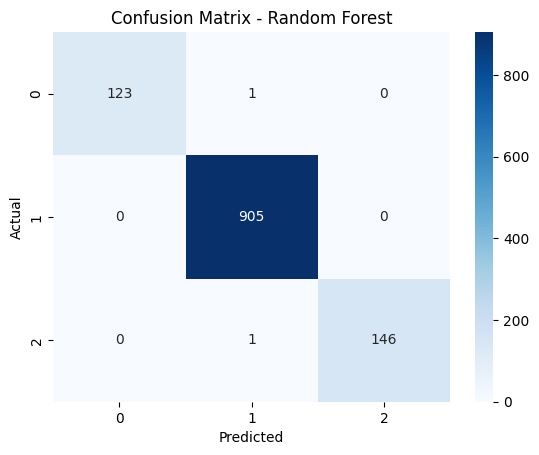


Gradient Boosting Regression Metrics:
MAE: 0.0030659820598382573
MSE: 1.8786184693329264e-05
R2 Score: 0.9998566438119143


In [38]:
# Random Forest for classification
from sklearn.ensemble import RandomForestClassifier
clf3 = RandomForestClassifier()
clf3.fit(X_train_class, y_train_class)
y_pred_rf_class = clf3.predict(X_test_class)

# Gradient Boosting for regression
from sklearn.ensemble import GradientBoostingRegressor
reg2 = GradientBoostingRegressor()
reg2.fit(X_train_reg, y_train_reg)
y_pred_gbm_reg = reg2.predict(X_test_reg)

# Evaluate the models
evaluate_classification("Random Forest", y_test_class, y_pred_rf_class)
evaluate_regression("Gradient Boosting", y_test_reg, y_pred_gbm_reg)
